# **NZ Space Challenge**

The final 2-in-1 combination of Crevasse Finder and Route Finder notebooks. An end to end solution for routing across crevasses in Antarctica!

Consists of two main parts:

1. classifier = Our crevasse finder classification model, trained using Supervised Learning (Convolutional Neural Network)
2. navigator = Our route finder navigational model, trained using Reinforcement Learning (Asynchronous Advantage Actor-Critic Network)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  #set to see only the 4th gpu
os.environ['KERAS_BACKEND'] = 'tensorflow'
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [2]:
import random
import sys

import fiona
import geopandas as gpd
import rasterio
import shapely.geometry

from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import pandas as pd

import keras
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential, Model
from keras.layers import Concatenate, Input, Add, Cropping2D, ZeroPadding2D
from keras import backend as K
from keras.layers import Lambda
import tensorflow as tf
import tensorflowjs as tfjs

from model_architectures import crevasse_finder_model, route_finder_model, CrevasseCrosserEnv

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
Numpy        : 1.14.2
Keras        : 2.1.5
Tensorflow   : 1.7.0


'/device:GPU:0'

In [3]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
tf.set_random_seed(seed=seed)

In [4]:
# import our data from quilt!
import quilt
quilt.install(package='weiji14/nz_space_challenge', hash='706b30f3', force=True)
from quilt.data.weiji14 import nz_space_challenge

100%|██████████| 490M/490M [00:00<00:00, 61.8GB/s]

### Reload our models and their trained weights

In [5]:
observation_window=(256,256,1)
classifier = crevasse_finder_model()
navigator = route_finder_model()

In [6]:
classifier.load_weights(filepath="model/weights/crevasse-model-weights.hdf5")
navigator.load_weights(filepath="model/weights/navigator-actor-model-weights.hdf5")

### Look at our model architecture separately

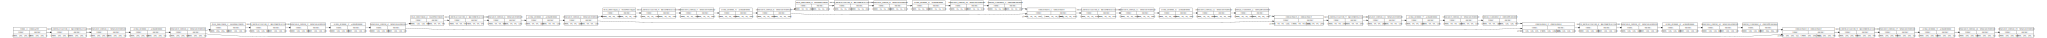

In [7]:
# Display U-Net Convolutional Neural Network 'Classifier' model
SVG(model_to_dot(model=classifier, show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))  #Change rankdir to 'TB' to see top-bottom flow diagram

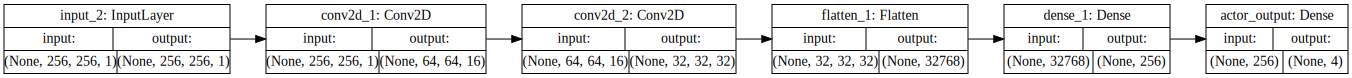

In [8]:
# Display the Deep Reinforcement Learning agent's inner Convolutional Neural Network 'Navigator' model
SVG(model_to_dot(model=navigator, show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))
#SVG(model_to_dot(model=navigator.critic, show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))

## Join the models!

1. **Classifier** - Take an raw cropped input MODIS MOA image of shape (256,256,1), and create an output crevasse map of shape (256,256,1)

2. **Joiner** - Joins the classifier's output of shape (256,256,1) to the navigator's input of shape (256, 256, 1) after providing the border direction hint input.

3. **Navigator** - Take the resampled crevasse map input of shape (256,256,1) and produce a Q value output of shape (4,) that corresponds to actions "left, down, right or up"

In [9]:
input_image = Input(shape=(256,256,1), name='input_image')

## Classifier
X = classifier(inputs=input_image)                             #converts input image to crevasse map

## Border work
X = Cropping2D(cropping=((4,4),(4,4)), name='crop_border')(X)  #crop out 4 pixels along border
X = ZeroPadding2D(padding=(4,4), name='zero_pad_border')(X)    #create 4 pixel border of zeros
input_border = Input(shape=(256,256,1), name='input_border')   #takes an input image with 4 pixel border direction hints
X = Add()([X, input_border])                                   #adds the border to the crevasse map!

## Navigator
q_values = navigator(inputs=X)

master_model = Model(inputs=[input_image, input_border],      #inputs raw EO image and border hint
                     outputs=[q_values, X])                   #outputs action q_values and intermediate crevasse output

In [10]:
master_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 256, 256, 1)  2383917     input_image[0][0]                
__________________________________________________________________________________________________
crop_border (Cropping2D)        (None, 248, 248, 1)  0           model_1[1][0]                    
__________________________________________________________________________________________________
zero_pad_border (ZeroPadding2D) (None, 256, 256, 1)  0           crop_border[0][0]                
__________________________________________________________________________________________________
input_bord

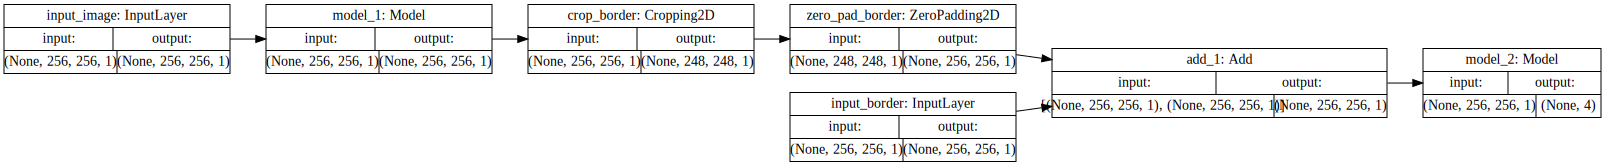

In [11]:
SVG(model_to_dot(model=master_model, show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))

In [12]:
raise ValueError('temp')

ValueError: temp

In [ ]:
#tfjs.converters.save_keras_model(model=master_model, artifacts_dir='tfjs')

# **Running on imagery input**

## Declare some functions first

In [ ]:
def get_padded_border(current_xy:tuple, end_xy:tuple, observation_shape=(256,256,1), observation_dtype=np.float32):
        #print(f'current_xy: {geo_midx,geo_midy}, end_xy: {self.end_xy}' )
        x_diff = end_xy[0] - current_xy[0]
        y_diff = end_xy[1] - current_xy[1]
        #print(f'x_diff {x_diff}, y_diff {y_diff}')
        
        padded_observation = np.full(shape=observation_shape, dtype=observation_dtype, fill_value=1)
        half_val = 0.5
        
        if x_diff <= 0: #i.e. if our goal lies to the left of the image
            padded_observation[0:observation_shape[0], :observation_shape[0]//2, :] -= np.array([half_val], dtype=observation_dtype)  #decrease penalty of left half 
        if x_diff >= 0: #i.e. if our goal lies to the right of the image
            padded_observation[0:observation_shape[0], observation_shape[0]//2:, :] -= np.array([half_val], dtype=observation_dtype)  #decrease penalty of right half
        
        if y_diff <= 0: #i.e. if our goal lies to the bottom of the image
            padded_observation[observation_shape[0]//2:, 0:observation_shape[1], :] -= np.array([half_val], dtype=observation_dtype)  #decrease penalty of bottom half
        if y_diff >= 0:  #i.e. if our goal lies to the top of the image
            padded_observation[:observation_shape[0]//2, 0:observation_shape[1], :] -= np.array([half_val], dtype=observation_dtype)  #decrease penalty of top half
        
        padded_observation[4:-4, 4:-4, :] = np.zeros_like(a=padded_observation[4:-4,4:-4,:])   #fill in centre of padded_observation with actual observation
        
        return padded_observation

def action_direction_mask(observation:np.array):
        """Custom action mask which looks at observation border hints to null out actions not heading towards goal"""
        mask = [False, False, False, False]  #0 left, 1 down, 2 right, 3 up
        if float(observation[:1, :1, :]) == 1.0:    #upper left corner, corresponding to actions 0 left and 3 up
            mask[0], mask[3] = (True, True)
        elif float(observation[:1, -1:, :]) == 1.0:  #upper right corner, corresponding to actions 2 right and 3 up
            mask[2], mask[3] = (True, True)
        elif float(observation[-1:, :1, :]) == 1.0:  #bottom left corner, corresponding to actions 0 left and 1 bottom
            mask[0], mask[1] = (True, True)
        elif float(observation[-1:, -1:, :]) == 1.0: #bottom right corner, corresponding to actions 1 bottom and 2 right
            mask[1], mask[2] = (True, True)
        
        return mask

## 1) Test on 1 sample tile (the tiled input MODIS MOA images used to train crevasse_finder.ipynb)

In [ ]:
X_data = np.load(nz_space_challenge.train.X_data())
print(X_data.shape)  #shape (m, height, width, channels)

In [ ]:
id = 128
sample_tile = X_data[id:id+1,:,:,:]  #get one single tile of shape (1, height, width, channels)
print(sample_tile.shape)

In [ ]:
# Run input image through classifier, (resampling), and navigator model to get action Q-values and intermediate crevasse_map
q_values, crevasse_output = master_model.predict(x=sample_tile)
best_action = ['Left', 'Down', 'Right', 'Up'][np.argmax(q_values)]

In [ ]:
## Show everything as a three series image!
fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(15,15))
## Left plot is input MODIS MOA image
axarr[0, 0].imshow(sample_tile[0,:,:,0])

## Centre plot is the resampled crevasse map, brown is likely crevasse, green are safe zones
axarr[0, 1].imshow(-crevasse_output[0,:,:,0], cmap='BrBG')
upper_left_y = observation_window[0]/2 - 1 - 0.5 
upper_left_x = observation_window[1]/2 - 1 - 0.5
axarr[0, 1].add_patch(matplotlib.patches.Rectangle(xy=(upper_left_x,upper_left_y), width=2, height=2,
                                                   fill=False, edgecolor='red', linewidth=2))

## Right plot is a zoomed in view of centre of the crevasse map
axarr[0, 2].imshow(-crevasse_output[0,60:68,60:68,0], cmap='BrBG')

print(f"Best decided action to take is {best_action} based on q_values {q_values}")

## 2) Run on Ross Ice Shelf!!

In [ ]:
with rasterio.open(fp=nz_space_challenge.intertrain.earthobservation_map()) as raster_source:
    map_env = raster_source.read(indexes=list(range(1,raster_source.count+1)), masked=True)  #outputs a masked numpy array of shape (1, height, width)
    map_env = np.moveaxis(a=map_env, source=0, destination=2)
    map_env = (map_env/2**16).astype(newtype=np.float32)  #rescale uint16 X_data to float32 values between 0 and 1
    
    transform = raster_source.transform
    print(transform)

In [ ]:
start_xy = (-92496,-1047621)
end_xy = (-96155,-1046808)
real_env = CrevasseCrosserEnv(map_env=map_env, observation_window=(256,256,1), pad_border=False,
                              transform=transform, start_xy=start_xy, end_xy=end_xy)
xy_list = []

In [ ]:
observation = real_env.reset()
current_xy = start_xy
crevasse_map_env = np.full_like(a=map_env, dtype=np.float32, fill_value=0.5)

## TODO fix image and geographic pixel imperfections

for i in range(20):
    # Reset gym environment
    real_env = CrevasseCrosserEnv(map_env=map_env, observation_window=(256,256,1), pad_border=False, transform=transform, start_xy=current_xy, end_xy=end_xy)
    crevasse_env = CrevasseCrosserEnv(map_env=crevasse_map_env, observation_window=(256,256,1), transform=transform, start_xy=current_xy, end_xy=end_xy)
    
    # Feed environmental observation into neural network model to get action
    padded_border = get_padded_border(current_xy=current_xy, end_xy=end_xy)
    model_inputs = [observation[np.newaxis,:], padded_border[np.newaxis,:]]
    action_probs, crevasse_observation = master_model.predict(x=model_inputs)
    action_probs = np.ma.array(data=action_probs, mask=action_direction_mask(observation=crevasse_observation[0,:,:,:]))
    action = np.argmax(action_probs)
    
    # Take a step based on the action chosen
    observation, _, _, _ = real_env.step(action=action)
    _, reward, done, info = crevasse_env.step(action=action)
    
    # Update crevasse view of the environment
    pixel_midx, pixel_midy = (info['pixel_x'], info['pixel_y'])
    crevasse_map_env[pixel_midy-128:pixel_midy+128, pixel_midx-128:pixel_midx+128,:] = crevasse_observation
    
    # Update geographic coordinates
    geores_x, geores_y = transform.a, transform.e
    current_xy = (info['geo_x']-geores_x, info['geo_y']-geores_y)  #minus geo resolution as we are taking coordinates from lower right corner of pixel
    xy_list.append(current_xy)
    
    # Print info and plot map render!
    best_action = ['Left', 'Down', 'Right', 'Up'][action]
    print(f"Best action to take was {best_action} out of {action_probs}, reward: {reward}")
    print(f"coords at {current_xy}, dist_to_goal: {info['geodist_to_goal']}")
    if i > 0:
        crevasse_env.render()

In [ ]:
print(crevasse_map_env.shape)
plt.imshow(-crevasse_map_env[:,:,0])
plt.imshow(-crevasse_map_env[2450:2800,4500:4800,0], cmap='BrBG')

In [ ]:
print(len(xy_list))
linestring = shapely.geometry.LineString(coordinates=xy_list)
linestring

In [ ]:
gs = gpd.GeoSeries(data=[linestring])
gs.crs = {'init': 'epsg:3031'}
gdf = gpd.GeoDataFrame(pd.DataFrame(data=[0], columns=['index']), geometry=gs, crs=gs.crs)

In [ ]:
gdf.plot(figsize=(10,10))

In [ ]:
#%% Export GeoDataFrame to GeoJson format!
assert('GeoJSON' in fiona.supported_drivers)
try:
    filename = 'track'
    gdf.to_file(filename=f'{filename}_epsg3031.geojson', driver='GeoJSON')
    gdf.to_crs(epsg=4326).to_file(filename=f'{filename}_epsg4326.geojson', driver='GeoJSON')
except:
    raise
    pass
finally:
    print('Exported data to:', f'{filename}_epsg????.geojson')

In [ ]:
from owslib.wms import WebMapService
import PIL.Image
import io

In [ ]:
from owslib.wms import WebMapService
wms = WebMapService('https://nsidc.org/cgi-bin/atlas_south?', version='1.1.1')

In [ ]:
wms['antarctica_satellite_image'].styles

In [ ]:
size = (25600,25600)
start_xy = (-96155,-1047621)
x0, x1 = start_xy[0]-size[0], start_xy[0]+size[0]  #left, right
y0, y1 = start_xy[1]-size[1], start_xy[1]+size[1]  #bottom, top
assert(x0 < x1)
assert(y0 < y1)
bbox = (x0, y0, x1, y1)
print(bbox)

In [ ]:
img = wms.getmap(layers=['antarctica_satellite_image'],
                 srs='EPSG:3031',
                 bbox=bbox,
                 size=(256,256),
                 format='image/jpeg',
                 transparent=True
                 )

In [ ]:
im = PIL.Image.open(io.BytesIO(img.read()))

In [ ]:
img_ary = np.array(object=im, dtype=np.uint8)
img = (img_ary/2**8).astype(dtype=np.float32)
plt.imshow(img)